# CS549 Machine Learning 
# Assignment 7 (Part 2): Character-Level RNN-Based Text Classification Model

**Total points: 10**

In this assignment, you will implement character-level RNN models that are used to classify the nationality of names.

This assignment is based on a tutorial from the PyTorch website: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html.
Some helper functions are adopted from the original example. 

The major difference is that you will use the `torch.nn.RNNCell` provided in PyTorch as your basic building block, instead of writing a RNN cell yourself from scratch.

---

## Import packages

In [1]:
import torch
import torch.nn as nn
import random
from rnn2_utils import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
print('num of classes:', n_categories)
print('num of letters:', n_letters)

num of classes: 18
num of letters: 57


---
## Task 1. Defining the network

**2 points**

Define a single directional RNN model.

**Instructions**
- An RNN cell `rnn_cell`, a fully-connected layer `self.fc`, and a softmax layer `self.softmax` are defined in `__init__()`
- The computational graph is defined in `forward()`. The hidden state of the RNN cell is stored in the tensor `h`, which is of size `[batch_size, hidden_size]`. `forward()` takes as input the tensor `x` in of size `[seq_length, batch_size, input_size]`, whose first dimension is the time steps. Therefore, we use a `for` loop to iterate over the time steps, and for each time step, we feed the input at the current step, and the previous hidden state to the RNN cell. The cell then returns a new hidden state, which overrides `h`.
- Refer to the original tutorial and the API for `nn.RNNCell` for detailed information: https://pytorch.org/docs/stable/nn.html#rnncell.

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        """
        x: size [seq_length, 1, input_size]
        """
        h = torch.zeros(x.size(1), self.hidden_size)
        #print(x)
        for i in range(x.size(0)):
            ### START YOUR CODE ###
            h = self.rnn_cell(x[i,:,:],h)
            ### END YOUR CODE ###
        
        ### START YOUR CODE ###
        # Hint: first call fc, then call softmax
        out = self.softmax(self.fc(h))
        ### END YOUR CODE ###
        
        return out

In [4]:
# Evaluate Task 1
torch.manual_seed(0)
rnn = RNN(10, 20, 18)
input_data = torch.randn(6, 3, 10)

with torch.no_grad():
    out = rnn(input_data)
    
print(out.size())
print(out[0])

torch.Size([3, 18])
tensor([-3.3146, -3.0216, -2.9363, -3.1215, -2.7141, -2.7103, -2.9526, -3.0657,
        -2.9442, -3.0038, -2.6818, -2.7880, -2.9849, -3.1164, -2.5659, -2.5336,
        -2.9586, -2.9764])


**Expected output**

|&nbsp;|
|--|
|torch.Size([3, 18])|
|tensor([-3.3146, -3.0216, -2.9363, -3.1215, -2.7141, -2.7103, -2.9526, -3.0657,|
       | -2.9442, -3.0038, -2.6818, -2.7880, -2.9849, -3.1164, -2.5659, -2.5336,|
       | -2.9586, -2.9764])|

---

## Task 2. Training the model

**4 points**

Train the model with stachastic gradient descent. Due to the setting of the origianl tutorrial, one data example is used per iteration, i.e., the mini-batch size is 1.

**Instructions**
- Each training data example contains a name (`x`) and a label indicating its nationality (`y`). 
- The model uses the tensor version of `x` and `y`, i.e., `x_tensor` and `y_tensor`. Here `x_tensor` is of size `[seq_length, 1, input_size]`, in which `input_size` is the total number of letters.
- `x_tensor[0, 0, :]` as the one-hot encoding for the first letter in the string `x`, and so forth for `x_tensor[1, 0, :]` etc.
- The function will output the predicing result every 5000 iterations. You can find a general trend that the prediction is getting more accurate.

In [5]:
def train(model, n_iters = 100000, print_every = 5000, plot_every = 1000, learning_rate = 0.005):
    # Turn on the training model
    model.train()
    
    # Loss and optimizer
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    
    running_loss = 0
    all_losses = []
    
    # Train loop
    start = time.time()
    for i in range(n_iters):
        y, x, y_tensor, x_tensor = randomTrainingExample()
        
        ### START YOUR CODE ###
        # zero grad
        optimizer.zero_grad()
        
        # Forward pass
        output = model(x_tensor)
        loss = criterion(output,y_tensor)
        
        # Backprop and update
        loss.backward()
        optimizer.step()
        ### END YOUR CODE ###
        
        # Record loss
        running_loss += loss.item()
        
        # Print iter, loss, name, and guess
        if i % print_every == 0 and i > 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == y else '✗ (%s)' % y
            print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, x, guess, correct))
        
        # Append loss
        if i % plot_every == 0 and i > 0:
            all_losses.append(running_loss / plot_every)
            running_loss = 0
    
    # Plot
    plt.figure()
    plt.plot(all_losses)

5000 5% (0m 5s) 2.7187 Villanueva / Greek ✗ (Spanish)
10000 10% (0m 11s) 2.0185 Charbonneau / French ✓
15000 15% (0m 17s) 4.8491 Santillian / Scottish ✗ (Spanish)
20000 20% (0m 22s) 2.5057 Nogi / Korean ✗ (Japanese)
25000 25% (0m 27s) 2.1713 Tankoshitsu / Greek ✗ (Japanese)
30000 30% (0m 33s) 0.5022 Lawniczak / Polish ✓
35000 35% (0m 38s) 2.0176 O'Byrne / French ✗ (Irish)
40000 40% (0m 44s) 0.2090 Catalano / Italian ✓
45000 45% (0m 49s) 0.5786 Albert / French ✓
50000 50% (0m 55s) 2.3831 Tindall / Irish ✗ (English)
55000 55% (1m 0s) 2.0776 Richard / Scottish ✗ (Dutch)
60000 60% (1m 6s) 0.6985 O'Keeffe / Irish ✓
65000 65% (1m 12s) 1.1752 Verdon / English ✓
70000 70% (1m 17s) 1.7630 Rey / Dutch ✗ (French)
75000 75% (1m 23s) 0.8616 Abt / German ✓
80000 80% (1m 28s) 2.5082 Schmied / German ✗ (Czech)
85000 85% (1m 34s) 2.0300 Mohren / English ✗ (Dutch)
90000 90% (1m 39s) 0.5435 Pendlebury / English ✓
95000 95% (1m 45s) 0.6660 Seif / Arabic ✓


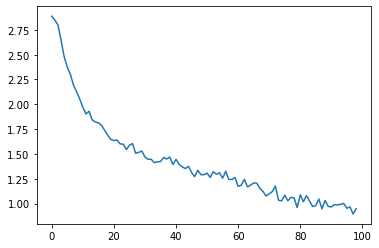

In [6]:
# Evaluate Task 2
# Be patient with the training speed :)
torch.manual_seed(0)
random.seed(0)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

train(rnn)

**Expected output**

|&nbsp;|&nbsp;|
|--|--|
|5000 5% (0m 8s) | 3.1065 Ba / Vietnamese ✗ (Arabic)|
|10000 10% (0m 17s)| 1.9009 Silva / Spanish ✗ (Portuguese)|
|15000 15% (0m 27s)| 0.9776 Salucci / Italian ✓|
|20000 20% (0m 36s)| 1.5460 Chaim / Korean ✗ (Chinese)|
|25000 25% (0m 47s)| 1.9412 Cruz / Spanish ✗ (Portuguese)|
|30000 30% (0m 57s)| 2.6189 Neusser / Dutch ✗ (Czech)|
|35000 35% (1m 8s) |0.4944 Ribeiro / Portuguese ✓|
|40000 40% (1m 18s)| 0.3007 Daher / Arabic ✓|
|45000 45% (1m 28s)| 1.5447 Guang / Vietnamese ✗ (Chinese)|
|50000 50% (1m 38s)| 0.9920 Mackenzie / Scottish ✓|
|55000 55% (1m 48s)| 2.6635 Moon / English ✗ (Korean)|
|60000 60% (1m 59s)| 2.5376 Boutros / Portuguese ✗ (Arabic)|
|65000 65% (2m 9s) |0.5595 Schuttmann / German ✓|
|70000 70% (2m 19s)| 1.6059 Spada / Japanese ✗ (Italian)|
|75000 75% (2m 30s)| 1.1130 Coilean / Irish ✓|
|80000 80% (2m 40s)| 0.6820 Schneider / German ✓|
|85000 85% (2m 50s)| 0.3628 Lopez / Spanish ✓|
|90000 90% (3m 1s) |1.1985 Tremblay / French ✓|
|95000 95% (3m 12s)| 1.0904 Knopf / German ✓|

---

## Task 3 Bi-directional RNN model
**4 points**

Implement a bi-directional RNN model by modifying the architecture of the `RNN` class.

**Instructions**
- Two distinct RNN cells are defined in `__init__()`. The input size for the fully-connected layer is doubled, because it needs take input the concatenated hidden states from the two cells.
- In `forward()`, two hidden states, `h1` and `h2`, are computed separately. `h1` is exactly the same as the previous `h` in one-directional `RNN`. `h2` is computed by reversing the order of the `for` loop: iterating from the last time step to the first time step.
- Concatenate `h1` and `h2` using `torch.cat()`. Notice that the correct dimension needs be specified. 

In [7]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn_cell1 = nn.RNNCell(input_size, hidden_size)
        self.rnn_cell2 = nn.RNNCell(input_size, hidden_size)
        
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        """
        x: size [seq_length, 1, input_size]
        """
        ### START YOUR CODE ###
        h1 = torch.zeros(x.size(1), self.hidden_size)
        for i in range(x.size(0)):
            h1 = self.rnn_cell1(x[i,:,:], h1)
        
        h2 = torch.zeros(x.size(1), self.hidden_size)
        for i in range(x.size(0)-1,-1,-1): # Hint: reverse the order of the for loop
            h2 = self.rnn_cell2(x[i,:,:], h2)
        #print(h1.size(),h2.size())
        h = torch.cat((h1,h2),dim=1)
        out = self.softmax(self.fc(h))
        ### END YOUR CODE ###
        
        return out

5000 5% (0m 9s) 2.6491 Villanueva / Polish ✗ (Spanish)
10000 10% (0m 18s) 1.6460 Charbonneau / French ✓
15000 15% (0m 28s) 4.7641 Santillian / Scottish ✗ (Spanish)
20000 20% (0m 37s) 1.4760 Nogi / Korean ✗ (Japanese)
25000 25% (0m 46s) 2.4161 Tankoshitsu / French ✗ (Japanese)
30000 30% (0m 55s) 0.4829 Lawniczak / Polish ✓
35000 35% (1m 5s) 0.7482 O'Byrne / Irish ✓
40000 40% (1m 14s) 0.1552 Catalano / Italian ✓
45000 45% (1m 23s) 0.7105 Albert / French ✓
50000 50% (1m 32s) 2.1894 Tindall / Irish ✗ (English)
55000 55% (1m 41s) 1.6873 Richard / French ✗ (Dutch)
60000 60% (1m 51s) 0.0916 O'Keeffe / Irish ✓
65000 65% (2m 0s) 1.0177 Verdon / English ✓
70000 70% (2m 9s) 1.8651 Rey / Dutch ✗ (French)
75000 75% (2m 19s) 1.5513 Abt / Scottish ✗ (German)
80000 80% (2m 28s) 2.7001 Schmied / German ✗ (Czech)
85000 85% (2m 37s) 0.4731 Mohren / Dutch ✓
90000 90% (2m 48s) 1.9638 Pendlebury / Czech ✗ (English)
95000 95% (2m 58s) 1.3754 Seif / Czech ✗ (Arabic)


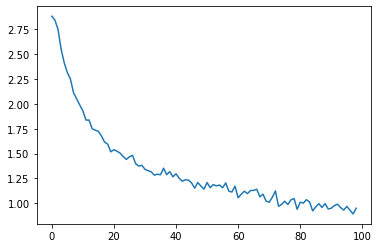

In [8]:
# Evaluate Task 3
# Be even more patient, as the training time is almost doubled :P
torch.manual_seed(0)
random.seed(0)

n_hidden = 128
birnn = BiRNN(n_letters, n_hidden, n_categories)

train(birnn)

**Expected output**

|&nbsp;|&nbsp;|
|--|--|
|5000 5% (0m 16s) | 2.9060 Ba / Vietnamese ✗ (Arabic)
|10000 10% (0m 33s)| 1.9203 Silva / Spanish ✗ (Portuguese)
|15000 15% (0m 51s)| 0.8597 Salucci / Italian ✓
|20000 20% (1m 10s)| 1.8664 Chaim / Vietnamese ✗ (Chinese)
|25000 25% (1m 29s)| 2.5580 Cruz / Spanish ✗ (Portuguese)
|30000 30% (1m 50s)| 3.2462 Neusser / Dutch ✗ (Czech)
|35000 35% (2m 8s) |0.4040 Ribeiro / Portuguese ✓
|40000 40% (2m 27s)| 0.3474 Daher / Arabic ✓
|45000 45% (2m 45s)| 1.1283 Guang / Vietnamese ✗ (Chinese)
|50000 50% (3m 3s) |1.4291 Mackenzie / Russian ✗ (Scottish)
|55000 55% (3m 20s)| 3.2796 Moon / Scottish ✗ (Korean)
|60000 60% (3m 38s)| 2.5028 Boutros / Portuguese ✗ (Arabic)
|65000 65% (3m 55s)| 0.0673 Schuttmann / German ✓
|70000 70% (4m 13s)| 1.3614 Spada / Italian ✓
|75000 75% (4m 30s)| 0.4321 Coilean / Irish ✓
|80000 80% (4m 47s)| 1.7251 Schneider / Dutch ✗ (German)
|85000 85% (5m 4s) |0.3610 Lopez / Spanish ✓
|90000 90% (5m 22s)| 1.3607 Tremblay / French ✓
|95000 95% (5m 40s)| 1.6964 Knopf / Czech ✗ (German)

Simply from the above output, it seems that BiRNN does not bring significant improvement.
Though we need more systematic evaluation.

---

## Congratulations!

Now you have built and trained models that can tell the nationality of a name. Try with the following functions on your own names!

In [9]:
def evaluate(model, x_tensor):
    model.eval()
    with torch.no_grad():
        output = model(x_tensor)
    return output


def predict(model, input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(model, lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [10]:
predict(birnn, 'Jose')
predict(rnn, 'Jose')

predict(birnn, 'Robinhood')
predict(rnn, 'Robinhood')

predict(birnn, 'Zhang')
predict(rnn, 'Zhang')

predict(birnn, 'Park')
predict(rnn, 'Park')

predict(birnn,'Jadon')
predict(rnn,'Jadon')

predict(birnn,'Marcus')
predict(rnn,'Marcus')


> Jose
(-0.67) English
(-2.25) Korean
(-2.30) German

> Jose
(-0.77) English
(-1.12) German
(-2.67) Dutch

> Robinhood
(-0.42) French
(-1.64) English
(-2.99) Dutch

> Robinhood
(-0.59) French
(-1.21) English
(-2.72) Scottish

> Zhang
(-0.06) Chinese
(-3.47) Korean
(-3.57) Vietnamese

> Zhang
(-0.11) Chinese
(-2.54) Korean
(-4.24) Vietnamese

> Park
(-1.20) Dutch
(-1.45) English
(-1.60) Czech

> Park
(-0.90) Dutch
(-1.54) English
(-1.99) Scottish

> Jadon
(-1.08) Russian
(-1.46) English
(-1.78) Polish

> Jadon
(-1.29) English
(-1.35) Russian
(-1.53) Korean

> Marcus
(-0.73) Portuguese
(-0.97) French
(-3.05) Spanish

> Marcus
(-0.02) Portuguese
(-4.47) French
(-4.79) Spanish
